# BCI Decodering m.b.v. de Spatiotemporele beamformer

Deze demo toont hoe uit een hersensignaal afgeleid kan worden welk
target een gebruiker van een brein-computer interface aanduidt.

## Dataset

Om te kunnen beginnen, word een publiek beschikbare dataset [1] gedownload.
Deze set bevat data van EEG experimenten waarin gebruikers telkens
het aangeduide object op het scherm moet selecteren met hun attentie.

De dataset bestaat uit meerdere stukjes EEG signaal van een bepaalde tijdsduur
(epochs) met elk de voltages gemeten met 8 verchillende electroden.
Elke epoch begint op het moment dat een target op het scherm flikkert.
Sommige van deze epochs komen overeen met het target dat de gebruiker probeert te selecteren
en bevatten dus een respons die gedetecteerd kan worden.

[1] Simões, Marco et al. “BCIAUT-P300: A Multi-Session and Multi-Subject Benchmark Dataset on Autism for P300-Based Brain-Computer-Interfaces.” Frontiers in neuroscience vol. 14 568104. 18 Sep. 2020, [doi:10.3389/fnins.2020.568104](https://doi.org/doi:10.3389/fnins.2020.568104)

In [1]:
from bciaut_to_mne import convert_to_mne
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Download the BCIAUT-P300 dataset from Kaggle
# If it doesn't already exist
if not os.path.exists('data'):
    kaggle = KaggleApi()
    kaggle.authenticate()
    kaggle.dataset_download_cli(dataset='disbeat/bciaut-p300',
                                unzip=True)
# Convert the .mat files to MNE format epochs
epochs = convert_to_mne('data/SBJ01/S01/Train/trainData.mat')
epochs

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1600 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


Number of events,1600
Events,stimulus/1: 200stimulus/2: 200stimulus/3: 200stimulus/4: 200stimulus/5: 200stimulus/6: 200stimulus/7: 200stimulus/8: 200
Time range,-0.200 – 1.196 sec
Baseline,off


Als een aantal epochs achter elkaar geplakt zouden worden,
zouden ze er ongeveer zo uitzien

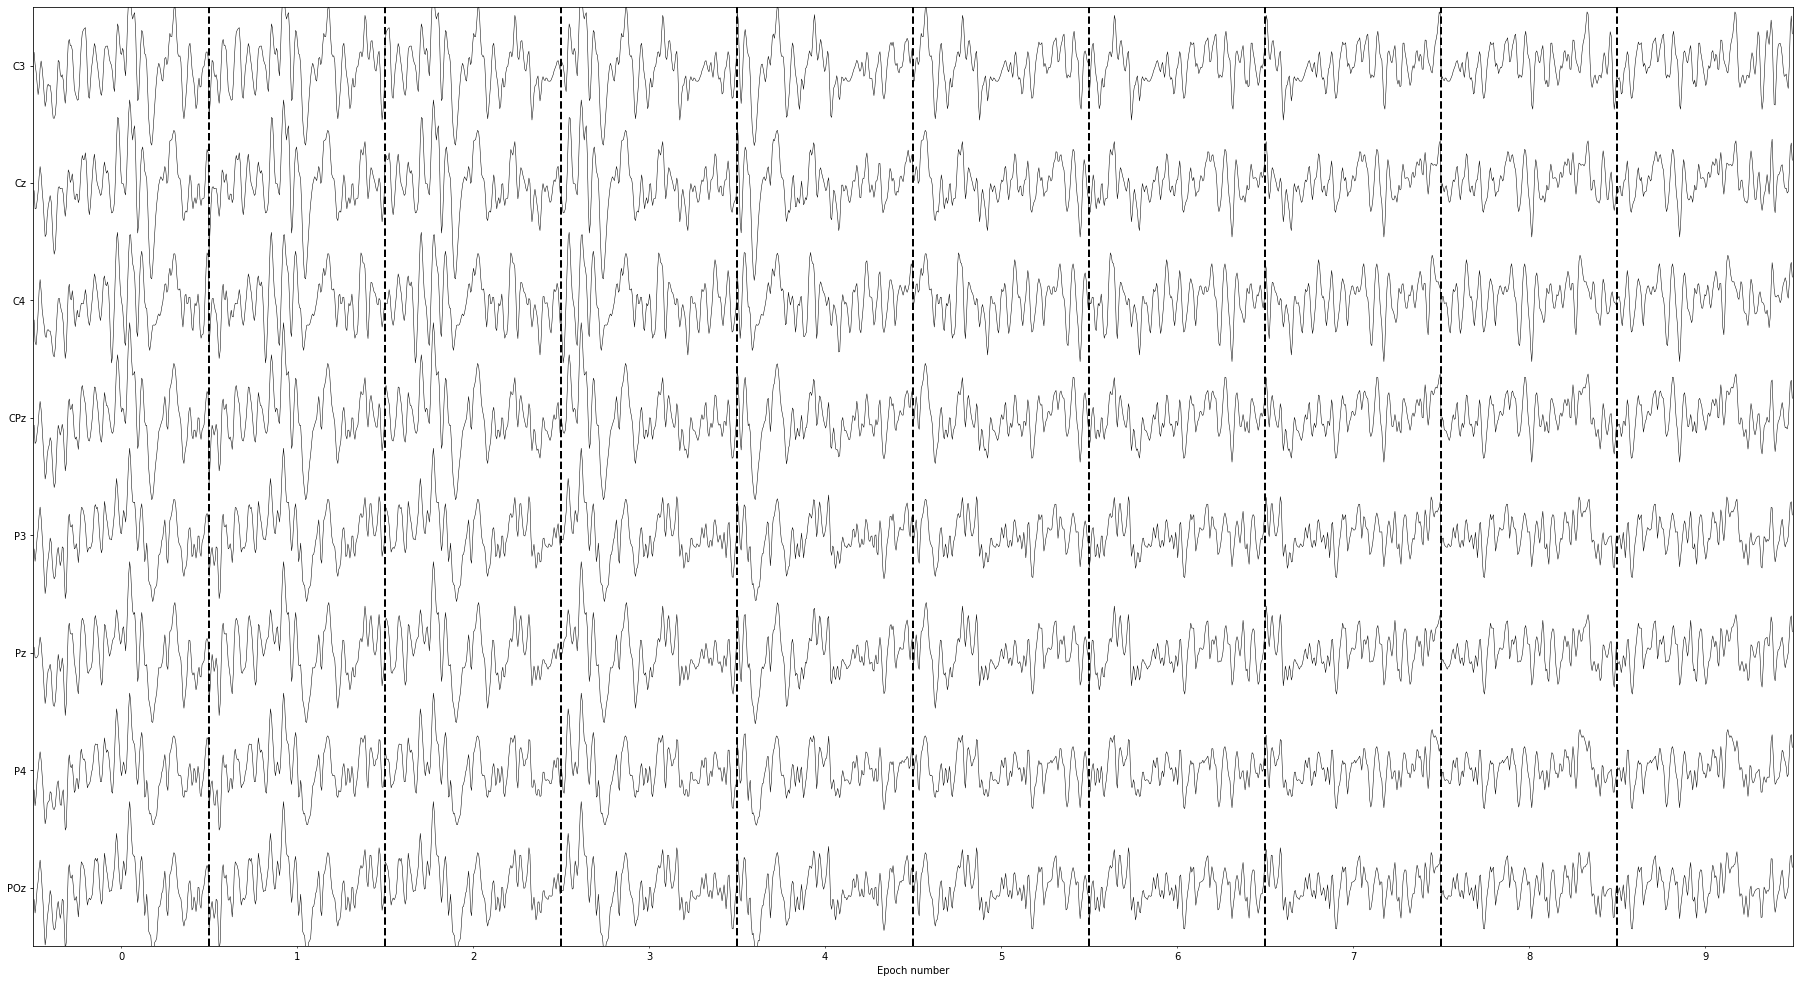

In [2]:
epochs[:10].plot(show_scrollbars=False);

## Ruis verwijderen

EEG data wordt heel gemakkelijk beïnvloed door elektrische apparaten,
bewegingen van de proefpersoon of andere activiteit in het brein waar
we niet in geïnteresseerd zijn.
Een EEG-signaal is daarom soms lastig te decoderen omdat het veel
ruis bevat.
Er worden een aantal stappen uitgevoerd om een deel van deze ruis te
verwijderen voor de verdere analyse kan beginnen:


1. Bepaalde frequentiebanden van het signaal worden weggefilterd
1. De epochs ingekort zodat ze enkel de respons bevatten en zo weinig
   mogelijk andere activiteit.
1. Er wordt gecompenseerd voor het feit dat sommige electroden
    beter contact maken dan andere, door de waarden van alle electroden
    naar hetzelfde bereik te schalen.

In [3]:
from mne.decoding import Scaler
from mne import EpochsArray

# Filter
epochs.filter(l_freq=None, h_freq=16)
# Crop
epochs.crop(tmin=0, tmax=1.0)
# Scale
scaler = Scaler(epochs.info, scalings='median')
epochs_data = scaler.fit_transform(epochs.get_data())
epochs = EpochsArray(epochs_data, info=epochs.info, tmin=epochs.tmin,
                     events=epochs.events, event_id=epochs.event_id,
                     metadata=epochs.metadata)

Setting up low-pass filter at 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 207 samples (0.828 sec)

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1600 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


De epochs zien er nu veel properder uit, maar zijn nog steeds vrij ruizig.

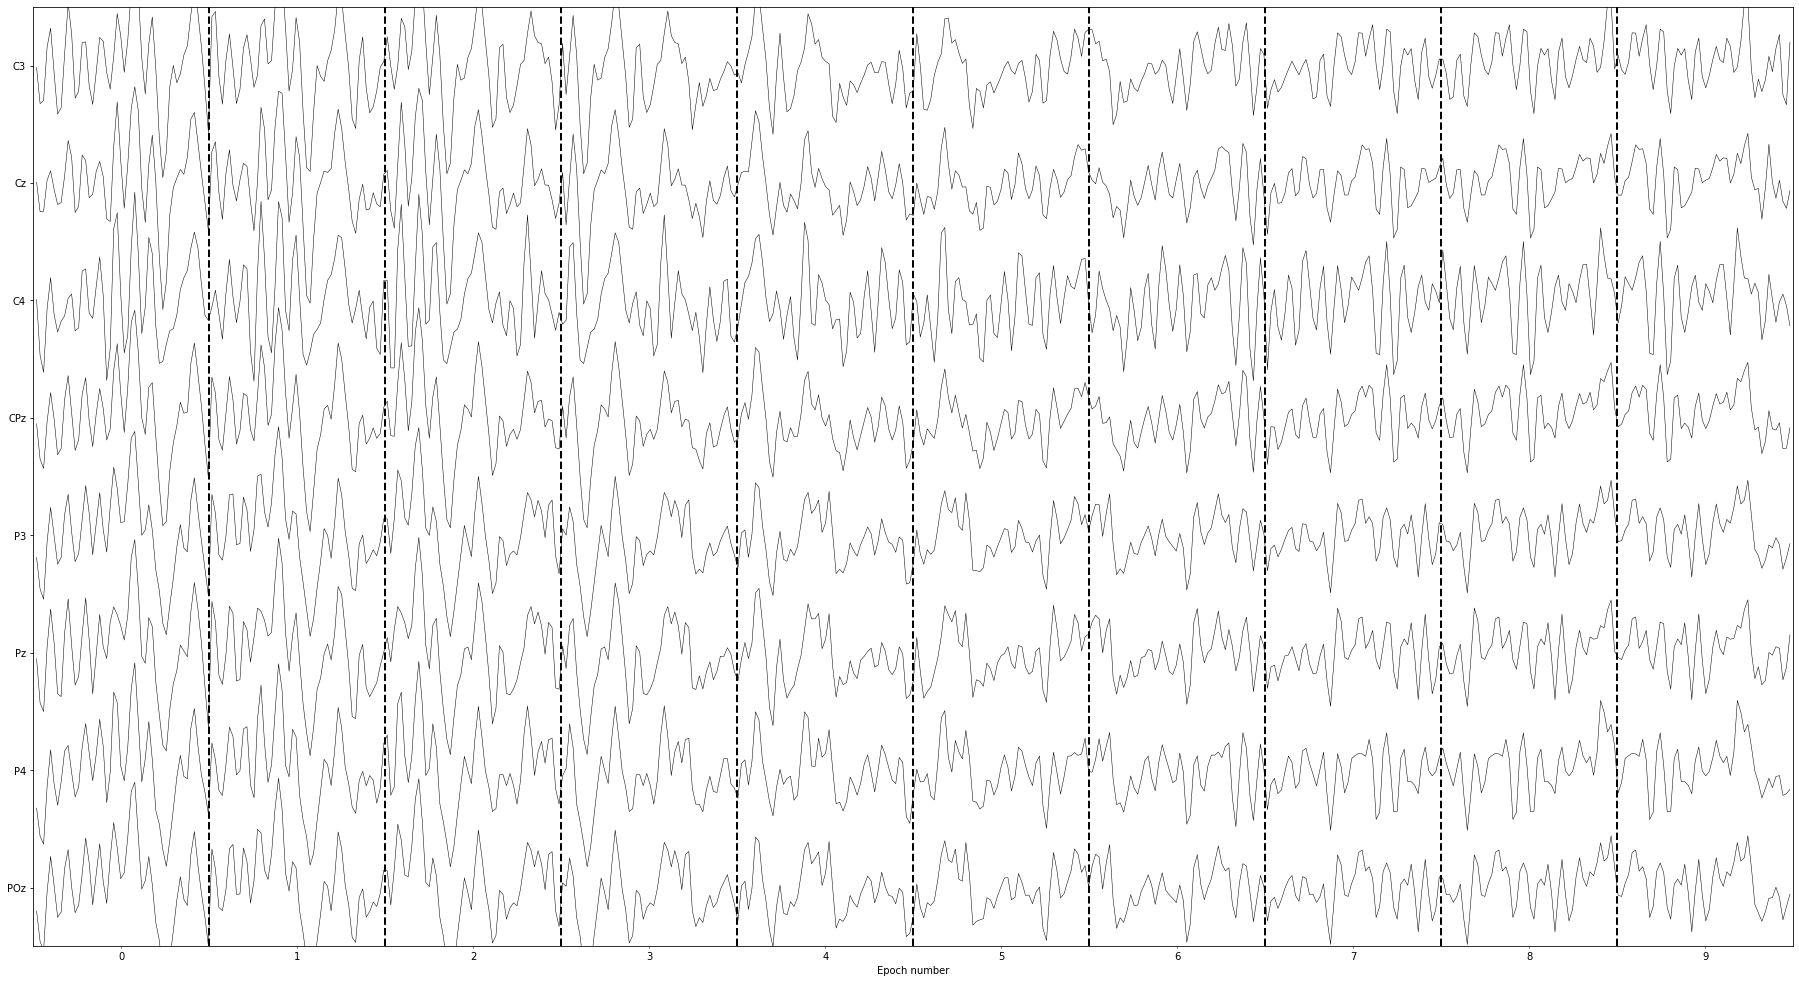

In [4]:
epochs[:10].plot(scalings=dict(eeg=1), show_scrollbars=False);

Daarom kijken we meestal naar het gemiddelde van veel epochs,
om enkel het signaal dat ze gemeenschappelijk bevatten over te houden en de rest te laten wegvallen.
Als we dit doen, zien we al duidelijk het verschil tussen het gemiddelde van de geselecteerde epochs
en het gemiddelde van de niet geselecteerde epochs.

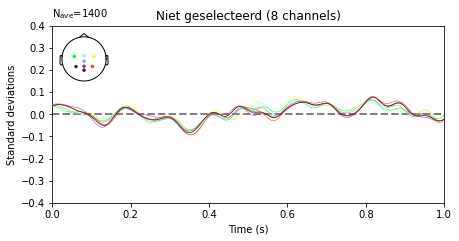

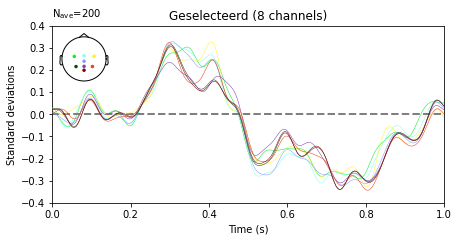

In [5]:
plot_kwargs =dict(spatial_colors=True,scalings=dict(eeg=1),
                 units=dict(eeg='Standard deviations'), hline=[0])

avg_not_selected = epochs['stimulus != cue'].average()
avg_not_selected.plot(ylim=dict(eeg=[-0.4, 0.4]),
                      titles=dict(eeg='Niet geselecteerd'),
                      **plot_kwargs)

avg_selected = epochs['stimulus == cue'].average()
avg_selected.plot(ylim=dict(eeg=[-0.4, 0.4]),
                  titles=dict(eeg='Geselecteerd'),
                  **plot_kwargs);


## Decodering

Om te bepalen of een epoch een respons op een geselecteerd target bevat,
wordt gebruik gemaakt van een machine learning
algoritme ontwikkeld aan de onderzoeksgroep voor Computationele Neurowetenschappen aan de KU Leuven:
de spatiotemporele beamformer.
Deze bepaalt een score voor elke epoch gebaseerd op een voorbeeld van het signaal
waarnaar gezocht wordt (activatiepatroon $a$) en informatie over hoe de verschillende kanalen en tijdstippen
van een epoch zich tot elkaar verhouden (covariantiematrix $\Sigma$).


Het activatiepatroon $a$ wordt berekend als het verschil van de gemiddelden van de
geselecteerde epochs en de niet geselecteerde epochs, zodat er enkel gekeken wordt
naar de verschillen tussen beide en de gemeenschappelijke componenten genegeerd worden.

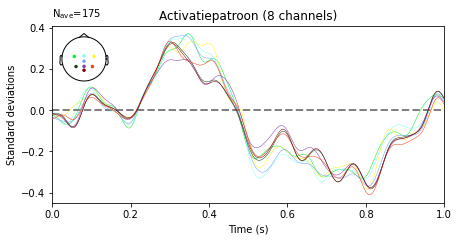

In [6]:
from mne import combine_evoked

activation_pattern = combine_evoked([epochs['stimulus == cue'].average(),
                                     epochs['stimulus != cue'].average()],
                                    weights=[1,-1])
activation_pattern.plot(**plot_kwargs,
                        titles=dict(eeg='Activatiepatroon'));


De covariantiematrix $\Sigma$ wordt berekend uit alle data.

In [ ]:
from mcbf.alg.covariance import SpatiotemporalLedoitWolf
import seaborn as sns

cov_estimator = SpatiotemporalLedoitWolf()
cov_estimator.fit(epochs.get_data())
sns.heatmap(cov_estimator.covariance_,
            cmap='BrBG', vmin=-1, vmax=1)


Tenslotte wordt de beamformer $w$ berekend via de volgende formule:

$$ w = \frac{\Sigma^{-1} a^\intercal}{a \Sigma^{-1} a^\intercal} $$

$w$ bevat gewichten die aangeven hoe zwaar bepaalde kanalen en tijdstippen
van een gegeven epoch meetellen in het bepalen van de score voor die epoch.

In [7]:
from mcbf.alg.beamformer import LCMVBeamformer
from mne import EvokedArray

stbf = LCMVBeamformer(lead_field=activation_pattern._data,
                      cov_estimator=cov_estimator)
stbf.fit(epochs.get_data())
weights_evoked = EvokedArray(stbf.weights_, epochs.info, epochs.tmin)
weights_evoked.plot(**plot_kwargs);


Om te bepalen welke epochs geselecteerd waren, wordt een score
berekend door elke epoch te vermenigvuldigen me $w$.
Een hoge score geeft aan dat een epoch waarschijnlijk geselecteerd was, maar zoals te zien
op onderstaande grafiek is er veel overlap tussen de scores voor geselecteerde en niet geselecteerde epochs,
en dus veel onzekerheid.

In [ ]:
import pandas as pd
scores = stbf.transform(epochs['run ==1'].get_data()).squeeze()
labels = epochs['run ==1'].metadata['stimulus'] \
         == epochs['run ==1'].metadata['cue']
result = pd.DataFrame({
    'Score': scores,
    'Geselecteerd': labels,
})
sns.displot(data=result, x='Score', hue='Geselecteerd')

Daarom wordt er vaak niet gewoon naar de score van een enkel epoch gekeken,
maar wordt de stimulatie herhaald en wordt er een score bepaalt voor het gemiddelde
van een aantal epochs die telkens een respons op dezelfde stimulatie bevatten.
Dit zorgt ervoor dat er veel ruis wegvalt en er een duidelijkere scheiding is
tussen geselecteerde en niet geselecteerde epochs.

In [ ]:
import numpy as np

avg_meta = epochs.metadata.copy()
avg_meta = avg_meta.reset_index()
avg_meta = avg_meta.groupby(['block', 'stimulus'], as_index=False)
avg_meta = avg_meta.agg({'cue': 'first', 'index': tuple})
avg_idc = np.vstack(avg_meta['index'].values)
avg_data = np.take(epochs.get_data(), avg_idc, axis=0)
avg_data = np.mean(avg_data, axis=1)

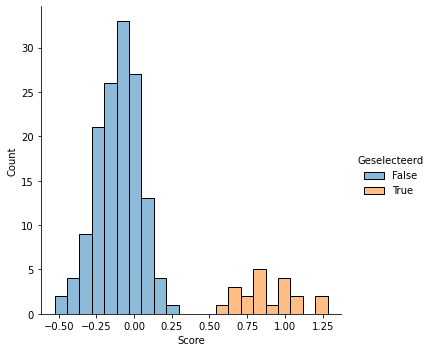

In [12]:
avg_scores = stbf.transform(avg_data).squeeze()
avg_labels = avg_meta['stimulus'] == avg_meta['cue']
avg_result = pd.DataFrame({
    'Score': avg_scores,
    'Geselecteerd': avg_labels,
})
sns.displot(data=avg_result, x='Score', hue='Geselecteerd')